In [1]:
import torch
import torch.nn as nn
from speechbrain.processing.speech_augmentation import AddNoise

from emonet.data_loader import TQDataset

/Users/christophersantiago/opt/miniconda3/envs/emonet2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from emonet import DATA_DIR
from torch.utils.data import DataLoader
from emonet.utils import play_audio
from emonet.plots import plot_spectrogram
from emonet.modules import RandomSegment

In [3]:
therapist = 'Michelle Lyn'
data = {
    'train': TQDataset(DATA_DIR.joinpath(therapist, 'train_splits.json'), DATA_DIR),
    'valid': TQDataset(DATA_DIR.joinpath(therapist, 'valid.json'), DATA_DIR, transform=RandomSegment(30)),
    'test': TQDataset(DATA_DIR.joinpath(therapist, 'test.json'), DATA_DIR, transform=RandomSegment(30)),
}

In [4]:
train_dl = DataLoader(data['train'], 1)
it = iter(train_dl)
b = next(it)

In [5]:
b[0].shape

torch.Size([1, 48000])

In [6]:
play_audio(b[0], 16000)

In [7]:
from speechbrain.processing.speech_augmentation import AddNoise

In [139]:
noise = AddNoise(snr_low=15, snr_high=30)
noisy = noise(b[0], torch.ones(1))
play_audio(noisy, 16000)

In [140]:
noisy.shape

torch.Size([1, 48000])

In [7]:
from torchaudio.transforms import MelSpectrogram, Spectrogram, Vol

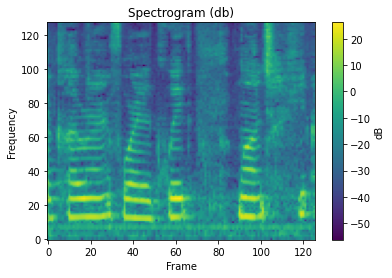

In [8]:
spec = MelSpectrogram(n_mels=128, n_fft=128*6)
s = spec(b[0])
plot_spectrogram(s.squeeze(), file="spec.png")  # batch size in first channel

In [26]:
s.size()

torch.Size([1, 128, 126])

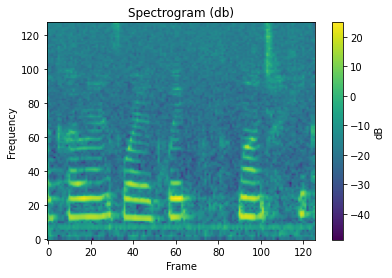

In [144]:
plot_spectrogram(spec(noisy).squeeze())  # batch size in first channel

In [154]:
import random

def add_noise(x):
    sig = random.uniform(0.02, 0.2)
    gaus = torch.zeros_like(x)
    gaus.normal_(0, sig)
    return gaus + x

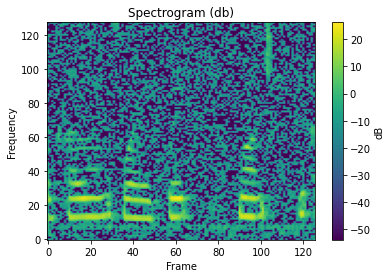

In [162]:
plot_spectrogram(add_noise(s).squeeze())

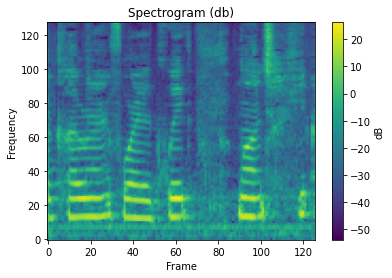

In [156]:
plot_spectrogram(s.squeeze())

## Chunking Spectrogram Data

In [27]:
s.shape

torch.Size([1, 128, 126])

In [9]:
b = s.unsqueeze(0)  # adding batch dim
splits = torch.chunk(b, 6, -1)
splits[0].shape

torch.Size([1, 1, 128, 21])

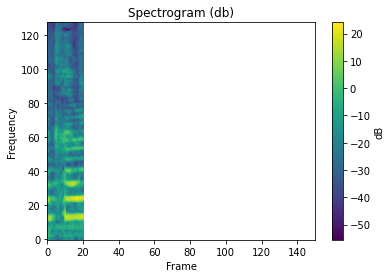

Chunk Size: torch.Size([1, 1, 128, 21])


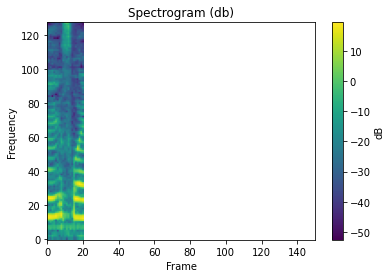

Chunk Size: torch.Size([1, 1, 128, 21])


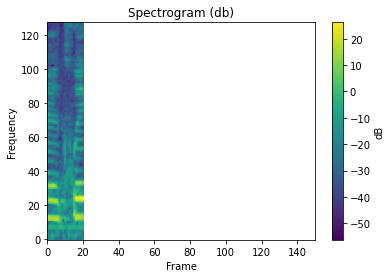

Chunk Size: torch.Size([1, 1, 128, 21])


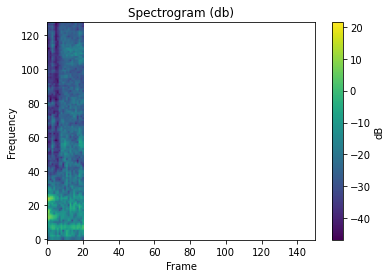

Chunk Size: torch.Size([1, 1, 128, 21])


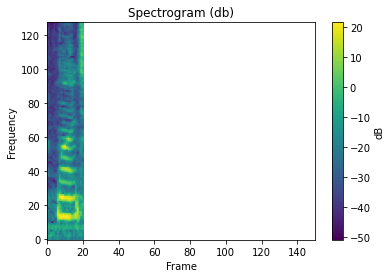

Chunk Size: torch.Size([1, 1, 128, 21])


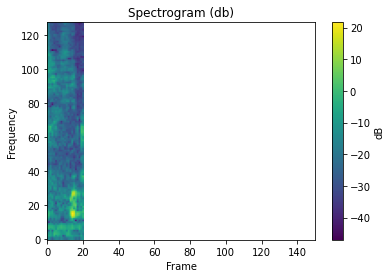

Chunk Size: torch.Size([1, 1, 128, 21])


In [13]:
for i, split in enumerate(splits):
    plot_spectrogram(split.squeeze(), xmax=150, file=f"spec-split-{i}.png")
    print(f'Chunk Size: {split.shape}')

In [19]:
chunked = torch.stack(splits, 1)
chunked.shape

RuntimeError: stack expects each tensor to be equal size, but got [1, 1, 128, 27] at entry 0 and [1, 1, 128, 26] at entry 5

## Time Distributed Modules to Chunks

In [39]:
class TimeDistributed(nn.Module):
    """
    Source: https://pytorch-forecasting.readthedocs.io/en/stable/_modules/pytorch_forecasting/models/temporal_fusion_transformer/sub_modules.html
    """
    def __init__(self, module: nn.Module, batch_first: bool = False):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y


In [49]:
class TimeDistributed(nn.Module):
    """
    batch first
    Source: https://github.com/Data-Science-kosta/Speech-Emotion-Classification-with-PyTorch/blob/master/notebooks/stacked_cnn_lstm.ipynb
    """
    def __init__(self, module):
        super(TimeDistributed, self).__init__()
        self.module = module

    def forward(self, x):

        if len(x.size()) <= 2:
            return self.module(x)
        # squash samples and timesteps into a single axis
        elif len(x.size()) == 3: # (samples, timesteps, inp1)
            x_reshape = x.contiguous().view(-1, x.size(2))  # (samples * timesteps, inp1)
        elif len(x.size()) == 4: # (samples,timesteps,inp1,inp2)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3)) # (samples*timesteps,inp1,inp2)
        else: # (samples,timesteps,inp1,inp2,inp3)
            x_reshape = x.contiguous().view(-1, x.size(2), x.size(3),x.size(4)) # (samples*timesteps,inp1,inp2,inp3)
            
        y = self.module(x_reshape)
        
        # we have to reshape Y
        if len(x.size()) == 3:
            y = y.contiguous().view(x.size(0), -1, y.size(1))  # (samples, timesteps, out1)
        elif len(x.size()) == 4:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2)) # (samples, timesteps, out1,out2)
        else:
            y = y.contiguous().view(x.size(0), -1, y.size(1), y.size(2),y.size(3)) # (samples, timesteps, out1,out2, out3)
        return y

In [50]:
time = TimeDistributed(nn.Identity())
time(chunked).shape

torch.Size([1, 6, 1, 128, 21])

In [51]:
x_reshape = chunked.contiguous().view(-1, chunked.size(-1))
x_reshape.shape  # (samples * timesteps, input_size)

torch.Size([768, 21])

In [52]:
conv = nn.Conv2d(
    in_channels=1,
    out_channels=16,
    kernel_size=3,
    stride=1,
    padding=1
)

y = conv(x_reshape.reshape((1, 1, 768, 21)))
y.shape

torch.Size([1, 16, 768, 21])

In [53]:
y = y.contiguous().view(chunked.size(0), -1, y.size(-1))  # batch first (samples, timesteps, output_size)
y.shape

torch.Size([1, 12288, 21])

In [54]:
m = TimeDistributed(conv)
m(chunked).shape

torch.Size([1, 6, 16, 128, 21])

In [55]:
batch = torch.ones((4, 1, 128, 126))
batch.shape

torch.Size([4, 1, 128, 126])

In [61]:
b_stack = torch.stack(b_splits, 1)
b_stack.shape  # (batch, chunks, channels, h, w)

torch.Size([4, 6, 1, 128, 21])

In [63]:
m(b_stack).shape

torch.Size([4, 6, 16, 128, 21])

## Idea for transformer

In [14]:
class WhiteNoise(nn.Module):
    def __init__(self, bs):
        super().__init__()
        self.bs = bs
        self.noise = AddNoise()
        
    def forward(self, x):
        return self.noise(x, torch.ones(self.bs))
        

noise = WhiteNoise(1)

transformers = nn.Sequential(
    WhiteNoise(1),
    MelSpectrogram(n_mels=64)
)

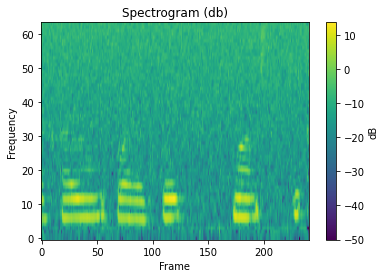

In [15]:
plot_spectrogram(transformers(b[0]).squeeze())

In [16]:
transformers(b[0]).reshape(1, -1)

tensor([[0.0013, 0.0664, 0.0758,  ..., 0.0934, 0.1281, 0.0755]])

## Idea validation/test steps

Essentially make `n` spectrograms for each item within a batch.  Get the average spectrogram per item and use that to validate on.

In [17]:
train_dl = DataLoader(data['train'], 4)
it = iter(train_dl)
b = next(it)

In [18]:
b

[tensor([[ 3.9876e-05,  1.3715e-04,  3.0458e-04,  ..., -8.9932e-03,
          -4.8718e-03, -1.3953e-04],
         [ 2.5744e-03,  8.5447e-03,  9.6993e-03,  ...,  2.7378e-03,
           2.2039e-03,  2.6234e-03],
         [ 3.3668e-03,  2.9733e-03,  2.8396e-03,  ...,  2.2343e-03,
           3.4320e-03,  1.4923e-03],
         [ 8.3923e-05,  2.6243e-03,  6.4999e-03,  ...,  5.1209e-03,
           5.4127e-03,  4.8938e-03]]),
 {'anger': tensor([3, 3, 3, 3]),
  'fear': tensor([2, 2, 2, 2]),
  'sadness': tensor([1, 1, 1, 1])}]

In [19]:
spec = MelSpectrogram(n_mels=64)
res = [spec(b[0]) for _ in range(5)]

In [20]:
res[0].shape

torch.Size([4, 64, 241])

In [21]:
torch.stack(res).shape

torch.Size([5, 4, 64, 241])

In [22]:
torch.stack(res).mean(0).shape

torch.Size([4, 64, 241])

-------

In [96]:
import torchvision.models as models

In [97]:
resnet = models.resnet18(pretrained=True)
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [34]:
model_wo_fc = nn.Sequential(*(list(resnet.children())[:-1]))

In [116]:
train_dl = DataLoader(data['train'], 1)
it = iter(train_dl)
b = next(it)

In [117]:
def channel1to3(t):
    bs = t.shape[0]
    h, w = t.shape[-2:]
    return s.expand((bs, 3, h, w))

In [120]:
model_wo_fc(channel1to3(s)).squeeze()

tensor([2.3749e+00, 1.2002e+00, 6.1316e-01, 2.8800e-01, 3.1211e-01, 1.7464e+00,
        1.1975e+00, 3.6088e-01, 4.2086e+00, 1.6196e-01, 2.8754e+00, 6.2348e-01,
        1.1293e+00, 1.2986e+00, 1.8423e+00, 3.8523e+00, 1.1156e-01, 6.9642e-01,
        5.4248e-01, 2.8365e+00, 1.6149e+00, 1.8931e+00, 1.2083e+00, 1.8806e+00,
        1.4489e+00, 2.3177e+00, 8.2824e-01, 3.3314e-01, 1.4317e+00, 2.1305e-01,
        1.1583e+00, 1.0073e+00, 1.7702e+00, 1.8066e+00, 2.8190e-01, 6.9338e-02,
        5.2238e+00, 2.9422e-01, 8.8992e-01, 2.2053e-02, 4.3172e-01, 7.9715e-01,
        2.8697e+00, 2.6555e+00, 1.3340e+00, 4.7814e-01, 1.0223e+00, 5.5857e+00,
        3.2115e+00, 1.6403e-01, 5.3595e-02, 2.9127e+00, 2.0949e+00, 1.0751e-01,
        1.2607e+00, 6.9454e-01, 1.9494e+00, 2.4161e+00, 1.7558e+00, 2.3981e-01,
        2.1969e+00, 5.5539e-01, 1.1476e+00, 1.2362e+00, 1.8780e+00, 2.0943e-01,
        1.9750e+00, 1.7230e-02, 1.0943e-01, 3.2947e+00, 3.6791e-01, 2.4743e-01,
        4.4987e-01, 1.1802e+00, 5.2951e-